# Культурист-датасаентист. Исследование оттока пользователей. Кластеризация.
<a id="home"></a>

        По данным анкет пользователей необходимо сформировать модель, которая позволяет спрогнозировать по данным 
    пользователя, перестанет ли он заниматься в фитнес-зале в следующем месяце. 
        Дополнительно необходимо разбить клиентов на подгруппы и проанализировать их.

    Содержание:
1. [Подготовка данных.](#stage_1)
    * [Знакомство с данными.](#get_aquainted_with_the_data)
    * [Вывод.](#summary_stage_1)
2. [Анализ данных.](#stage_2)
    * [Табличный анализ распределения признаков.](#analysis_table_x_matrix)
        * [Промежуточный итог.](#summary_middle_2_1)
    * [Графический анализ распределения признаков.](#analysis_graphs_x_matrix)
        * [Промежуточный итог.](#summary_middle_2_2)
    * [Корреляция.](#analysis_correlation)
        * [Промежуточный итог.](#summary_middle_2_3)
3. [Построение модели прогнозирования оттока пользователей.](#stage_3)
    * [Вывод.](#summary_stage_3)
4. [Кластеризация пользователей](#stage_4)
    * [Разбиение выборки на группы.](#make_cluster)
    * [Анализ кластеров.](#cluster_analysis)
5. [Общий вывод и рекомендации](#summary_stage_5)

## Подготовка данных.
<a id="stage_1"></a>

#### Знакомство с данными.
<a id="get_aquainted_with_the_data"></a>

In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

warnings.simplefilter("ignore")

        В качестве первого шага были загружены все необходимые библиотеки для данного проекта. Помимо основных для работы с 
    данными и визуализации (pandas, numpy, matplotlib, seaborn), были подгружены различные модули из библиотеки sklearn, в 
    которой содержится большое количество инструментов для прогнозирования. Во-первых, были загружены инструменты 
    стандартизации данных для регрессии, механизм для разбиения выборки на тренировочную и валидационную, во-вторых, две 
    модели -  LogisticRegression и RandomForestClassifier (обе эффективно решают задачи регрессии с бинарной 
    классификацией), в-третьих - метрики для оценки эффективности моделей, которые послужат критерием для выбора одной из 
    них.
        Для решения второй задачи, классификации клиентов, были загружены классификаторы и алгоритмы: linkage, KMeans.
        На следующим этапе выполним загрузку и знакомство с данными

In [2]:
# import dataset
gym_df=pd.read_csv('/datasets/gym_churn.csv')
# displaying general information
gym_df.info()
print(gym_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB
   gender  Near_Location  Partner 

        Данные были успешно загружено, пропусков нет, типы данных соответствуют логике переменных. Проведем проверку на 
    дубликаты.
        Насколько видно, у нас 13 параметров, определяющих значение целевой переменной 4 000 наблюдений - это достаточное 
    количество для построения достоверной прогнозирующей модели.

In [3]:
# looking for duplicates

print('Число полных дубликатов:', gym_df.duplicated().sum())

Число полных дубликатов: 0


        Дубликатов не обнаружено. Остается привести имена столбцов к одному регистру для удобства.

In [4]:
# columns in lower case
gym_df.columns = gym_df.columns.str.lower()
print(gym_df.columns)

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month',
       'churn'],
      dtype='object')


#### Вывод.
<a id="summary_stage_1"></a>

        Необходимые изменения сделаны. Поскольку БД не содержит никаких пропусков и дубликатов, можно перейти к 
    исследовательскому анализу данных.

[К оглавлению](#home)

## Анализ данных.
<a id="stage_2"></a>

        Основной задачей этой части проекта будет являться определение влияния факторов на формирование целевой переменной. 

#### Табличный анализ распределения признаков.
<a id="analysis_table_x_matrix"></a>

        Сперва посмотрим на общее распределение величин в БД. В случае с бинарными параметрами, на данном этапе 
    воспользуемся значением моды - наиболее часто встречающемуся значению. Это позволит сделать выводы о типичном значении 
    того, или иного параметра.
        Остальные числовые значения обработаем методом describe.

In [5]:
# distribution of values
print(gym_df.describe())
print()
print()
# mode calculation
print('Исследование Моды значений')
for column in ['gender', 'near_location', 'partner', 'promo_friends', 'phone','group_visits']:
    print('Значение моды',column,':',gym_df[column].mode())

            gender  near_location      partner  promo_friends        phone  \
count  4000.000000    4000.000000  4000.000000    4000.000000  4000.000000   
mean      0.510250       0.845250     0.486750       0.308500     0.903500   
std       0.499957       0.361711     0.499887       0.461932     0.295313   
min       0.000000       0.000000     0.000000       0.000000     0.000000   
25%       0.000000       1.000000     0.000000       0.000000     1.000000   
50%       1.000000       1.000000     0.000000       0.000000     1.000000   
75%       1.000000       1.000000     1.000000       1.000000     1.000000   
max       1.000000       1.000000     1.000000       1.000000     1.000000   

       contract_period  group_visits          age  \
count      4000.000000   4000.000000  4000.000000   
mean          4.681250      0.412250    29.184250   
std           4.549706      0.492301     3.258367   
min           1.000000      0.000000    18.000000   
25%           1.000000      0.00

        Начнем с описания числовых переменных.
        Что касается договорных отношений клиентов с фитнес-клубом, столбцы contract_period, month_to_end_contract, можно 
    сделать некоторые выводы. 
        Во-первых, в основном контракт в фитнес-зал приобретается на 1 месяц (в соответствии со значением медианы). Скорее 
    всего, на столь непродолжительный срок абонемент покупают "на пробу", в качестве эксперимента или, например, как 
    результат новогодней резолюции. Можно выдвинуть гипотезу о том, что подобные клиенты чаще всего перестают пользоваться 
    услугами фитнес-клуба спустя месяц. Если взглянуть на среднеквадратичное отклонение, мы видим, что разброс длительности 
    абонемента высок - 4 месяца. При этом 75% значений составляют от 1 до 6 месяцев.
        Во-вторых, столбцы contract_period, month_to_end_contract имеют почти идентичное распределние, причем столбец 
    month_to_end_contract является производным от contract_period. Исходя из этого, предполагаем наличие сильной корреляции 
    между этими признаками. Скорее всего, от одного из них можно легко избавиться без потери качества модели.
        Теперь рассмотрим распределение признаков, связанных с посещаемостью - avg_class_frequency_total и 
    avg_class_frequency_current_month. Они также обладают похожим распределением. В этом случае данные, из кторых составлен 
    столбец avg_class_frequency_current_month содержатся в avg_class_frequency_total. Таким образом, между признаками 
    наверняка будет сильная корреляция. При этом, если забыть о задаче моделирования будущего поведения клиентов, можно 
    увидеть, что привычки культуристов в основном, не меняются. В лучшем случае, большинство ходит в зал 1-2 раза в неделю. 
        Интересные особенности можно установить, если изучить распределение столбца lifetime. В основной массе клиенты 
    начали общение с сотрудниками фитнес-центра 5 месяцев назад. В ТЗ не сказано, что является началом отсчета в lifetime, 
    но, судя по периоду заключаемых контрактов, это явно не дата с момента посещения первого занятия по контракту. Скорее 
    всего, точкой отсчета во взаимодействии сотрудников с клиентами является заполнение формы обратной связи и т.п. Если 
    это так, получается, что в среднем с момента первого обращения в фитнес центр до текущего момента прошло 3 меяца. 
    Получается, у организации есть доволно большое число новых клиентов, а вот лояльных не так много.
        Средний возраст составляет 29 лет. 
        Наконец, дополнительные суммы трат клиентов имеют максимальный параметр средневквадратичного отклонения. Это 
    значит, что среди посетителей много как тех, кто не покупает ничего, так и тех, кто активно пользуется дополнительными 
    услугами компании.        

        Теперь можно перейти к бинарным параметрам.
        Исходя из рассчитанной моды, фитнес-центр находится в спальном районе, (близко к дому, но далеко от офиса), его 
    костяк составляют клиенты с полом "1" (необходимо запросить дополнительные сведения о значениях бинарных переменных).
        Групповые занятия в фитнес-центре не столь популярны. Сейчас можно предположить, что опция "Пригласи друга" 
    работает не совсем эффективно.
        Эти выводы являются предварительными. Необходимо подкрепить их графиками. Однако сначала посмотрим, как значения 
    параметров отличаются у разных групп. Примем факт оттока за "1".

In [6]:
# number parameters comparison in both groups
gym_groups_numbers = gym_df.groupby('churn').mean()
gym_groups_numbers.T

churn,0,1
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_additional_charges_total,158.445715,115.082899
month_to_end_contract,5.283089,1.662582


        В таблице четко видно разделение групп. Уходящие в "отток" клиенты берут абонементы на непродолжительные 
    срок, тратят меньше на дополнительные услуги и, в целом, реже ходят в зал. Похоже, что именно эти признаки будут иметь 
    в будущих регрессиях больший вес.
        Что касается бинарных параметров, отличие наблюдается только в параметре "partner". Отсюда можно сделать вывод, что 
    люди, пришедшие в зал по приглашению друга больше склонны к систематическому и долгому посещению тренажерного зала.
        Следующей задачей будет визуализация различий присутствующих групп клиентов.

#### Вывод.
<a id="summary_middle_2_1"></a>

        Выводы в этой части задания:
        1) В основном контракт в фитнес-зал приобретается на 1 месяц. 75% контрактов приобретается на срок в 1-6 месяцев.
        2) Столбец month_to_end_contract является производным от contract_period. Исходя из этого, предполагаем наличие 
    сильной корреляции между этими признаками.
        3) Данные, из кторых составлен столбец avg_class_frequency_current_month содержатся в avg_class_frequency_total. 
    Между признаками наверняка будет сильная корреляция.
        4) Обычно клиенты ходят в зал 1-2 раза в неделю.
        5) Исходя из параметра lifetime, у организации есть доволно большое число новых клиентов, а вот лояльных не так 
    много.
        6) Фитнес-центр находится не в деловом районе.
        7) Групповые занятия не столь популярны.
        8) Опцией "Пригласи друга" пользуются не слишком часто.
        9) Уходящие в "отток" клиенты берут абонементы на непродолжительные срок, тратят меньше на дополнительные услуги и, 
    в целом, реже ходят в зал.
        10) Предположение: Люди, пришедшие в зал по приглашению друга больше склонны к систематическому и долгому посещению 
    тренажерного зала.

[К оглавлению](#home)

#### Графический анализ распределения признаков в двух группах.
<a id="analysis_graphs_x_matrix"></a>

        Поскольку у нас есть два основных типа данных - числовый и бинарные, необходимы разные типы графиков для понимания 
    распределения между ними. Мы сформируем две БД, в которых клиенты будут поделены по факту оттока. Далее будем 
    сравнивать попарно распределения между разными группами значений. 

In [8]:
# create two slices with different churn value
gym_slice_0 = gym_df.loc[gym_df['churn'] == 0].copy()
gym_slice_1 = gym_df.loc[gym_df['churn'] == 1].copy()
# create row with number and binar parameters:
num_param = ['contract_period',
             'age',
             'avg_additional_charges_total',
             'month_to_end_contract','lifetime',
             'avg_class_frequency_total','avg_class_frequency_current_month']
bin_param = ['gender','near_location',
             'partner','promo_friends',
             'phone','group_visits']

In [9]:
# making plots of number parameters

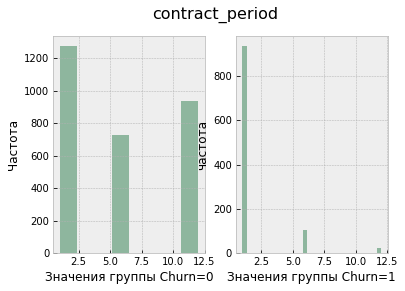

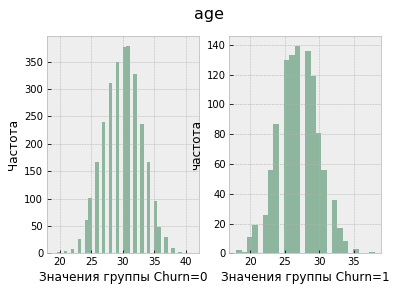

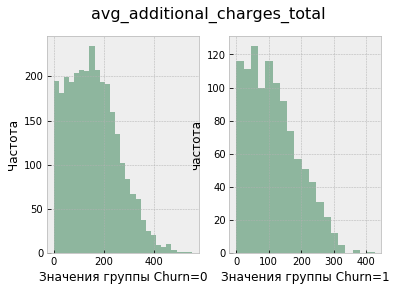

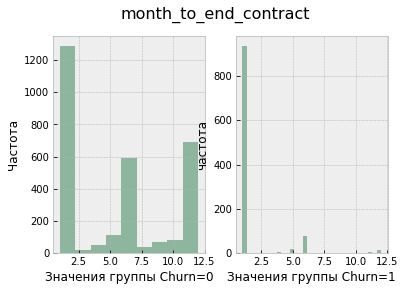

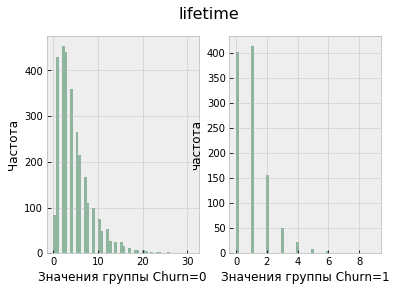

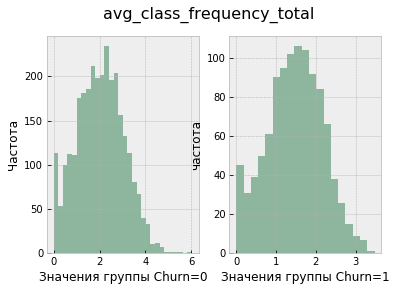

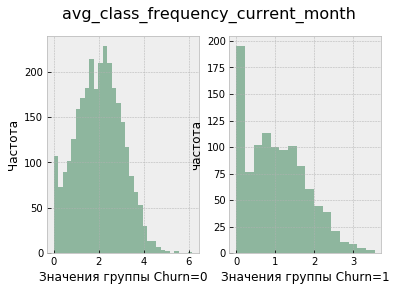

In [10]:
# setting plot style and pallete
plt.style.use('bmh')
sb.set_palette('BuGn_r', n_colors=10)
# Set up the matplotlib figure
for column in num_param:
    fig, axs = plt.subplots(ncols=2)
    sb.distplot(gym_slice_0[column],kde=False,ax=axs[0],axlabel = 'Значения группы Churn=0')
    sb.distplot(gym_slice_1[column],kde=False,ax=axs[1],axlabel = 'Значения группы Churn=1')
    fig.suptitle(column, fontsize=16)
    axs[0].set_ylabel("Частота")
    axs[1].set_ylabel("частота")
    plt.show()

        Визуализация подтвердила выводы, которые мы выдвигали в первой части описательного анализа: в целом значения 
    переменных у группы "оттока" в среднем ниже, чем в группе более лояльных клиентов.
        К интересным особенностям можно отнести наличие четких категорий среди лояльных клиентов по сроку действия 
    контракта. Контракт оформляют на 1,6,12 месяцев. Возможно, это деление является одной из возможных классификаций 
    клиентов. 
        На следующем этапе визуализируем распределение бинарных величин.

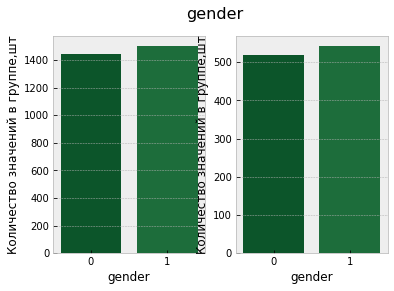

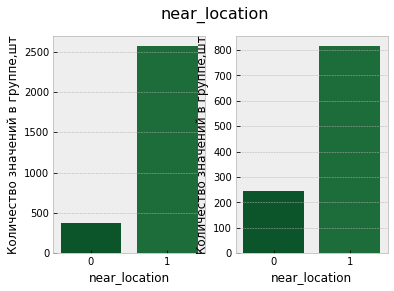

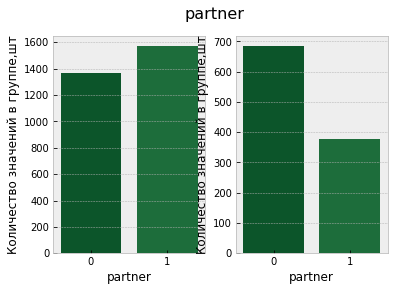

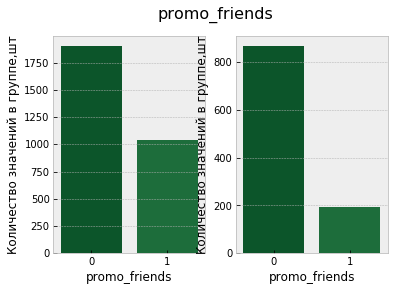

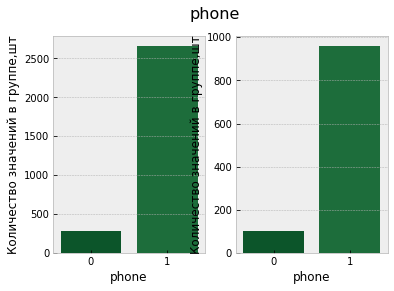

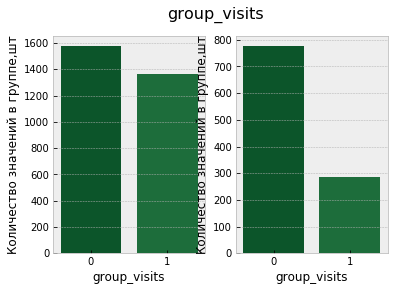

In [11]:
# Set up the matplotlib figure
for column in bin_param:
    fig, axs = plt.subplots(ncols=2)
    sb.countplot(x=column, data=gym_slice_0,ax=axs[0])
    sb.countplot(x=column, data=gym_slice_1,ax=axs[1])
    fig.suptitle(column, fontsize=16)
    axs[0].set_ylabel("Количество значений в группе,шт")
    axs[1].set_ylabel("Количество значений в группе,шт")
    plt.show()

        Данная визуализация оказалась более полезной. Как выяснилось, в зал ходят представители обоих полов примерно 
    одинаково. И, примерно одинаково они и бросают занятия.
        Наличие скидок для представителей компаний-партнеров мотивирует продолжать занятия спортом. Скорее всего коллеги 
    советуют фитнес-зал друг другу - об этом косвенно говорит увеличение количества целевых действий для параметра 
    "promo_friends". Снова, как следствие, доля посещений групповых занятий у клиентов "нулевой" группы выше. Отсюда можно 
    сделать вывод о том, что социальная составляющая важна для регулярных занятий спортом.

#### Вывод.
<a id="summary_middle_2_2"></a>

        Дополнительные выводы, полученные из графического анализа данных:
        1) Контракт оформляют на 1,6,12 месяцев.
        2) Наличие скидок для представителей компаний-партнеров мотивирует продолжать занятия спортом. 
        3) Социальная составляющая важна для регулярных занятий спортом.

[К оглавлению](#home)

#### Корреляция.
<a id="analysis_correlation"></a>

        К настоящему моменту уже был проведен подробный анализ данных, который позволяет сделать предположения, 
    относительно влияния факторов на значение целевой переменной. Корреляция скорее всего будет высокой между целевой 
    переменной и параметром участия клиента в партнерской программе, длительностью контракта с фитнес-залом, параметром 
    посещения групповых занятий и, возможно, средним количеством посещений в неделю. Также не стоит забывать о гипотезе 
    относительно наличия мультиколлинеарности.  
        Произведем проверку, построив матрице корреляции.

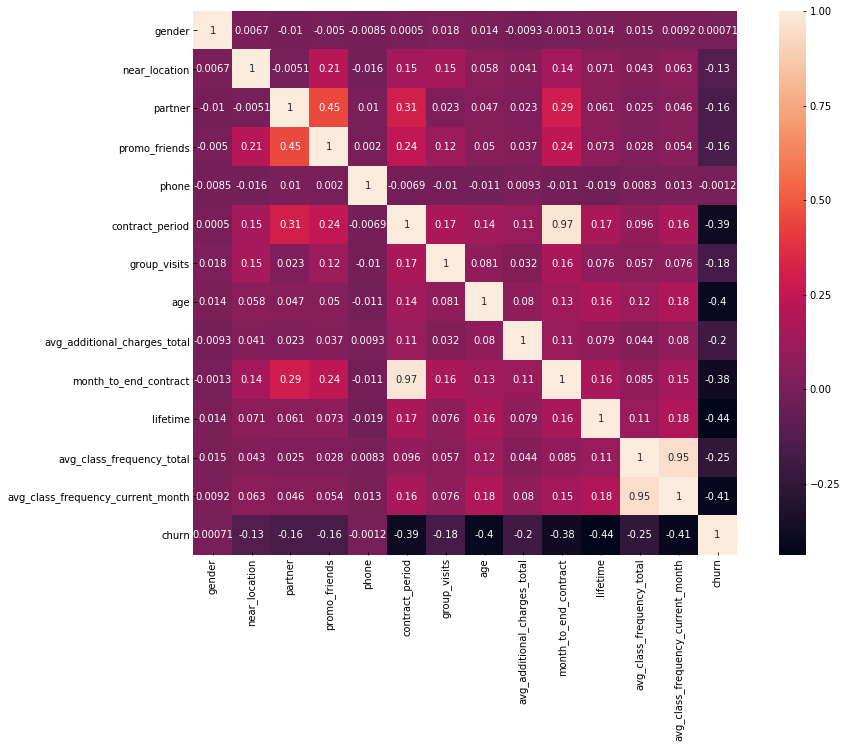

In [12]:
# creating correlation matrix
corr_matrix = gym_df.corr()
# making a nice plot
f, ax = plt.subplots(figsize=(15, 10))
sb.heatmap(corr_matrix, annot = True, square=True)
plt.show()

        Гипотеза о наличии мультиколлинеарности между разными параметрами посещения фитнес-зала и параметрами срока 
    договора подтвердилась. Следовательно, для того, чтобы модель давала точные прогнозы, один из параметров в каждой 
    группе необходимо удалить. Удаление произведем по принцпу наименьшей корреляции с целевой переменной - из БД выбывают 
    столбцы avg_class_frequency_current_month и contract_period.
        Относительно наших гипотез - подтвердились почти все, кроме сильного влияния времени, на которое заключается 
    договор.

In [13]:
# deleting above mentioned columns
del gym_df['avg_class_frequency_current_month']
del gym_df['contract_period']
print(gym_df.columns)

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'group_visits', 'age', 'avg_additional_charges_total',
       'month_to_end_contract', 'lifetime', 'avg_class_frequency_total',
       'churn'],
      dtype='object')


#### Вывод.
<a id="summary_middle_2_3"></a>

        1)Корреляция высока между целевой переменной и параметром участия клиента в партнерской программе, параметром 
    посещения групповых занятий и средним количеством посещений в неделю.
        2) Из-за наличия мультиколлинеарности параметры avg_class_frequency_current_month и contract period были удалены.

[К оглавлению](#home)

## Построение модели прогнозирования оттока пользователей.
<a id="stage_3"></a>

        В данном исследовании будут использованы две модели прогнозирования: LogisticRegression и RandomForestClassifier. 
    Для проведения последующих тестов необходимо, во-первых, стандартизировать данные (логистическая регрессия 
    чувствительна к вы масштабу данных), во-ворых, разбить общую выборку на тестовую (для обучения модели) и валидационную 
    (для проверки ее эффективности). После проведения тестов будут использованы метрики оценки эффективности прогнозов, так 
    можно будет определить, какую из моделей стоит использовать. 

In [14]:
# dividing df into parameters matrix and target variables vector
x_matrix = gym_df.drop('churn', axis = 1)
y = gym_df['churn']

In [15]:
# making test and train matrix
x_matrix_train, x_matrix_test, y_train, y_test = train_test_split(x_matrix, y, test_size=0.2, random_state=0)

In [16]:
# training Standard Scaler
scaler = StandardScaler()
scaler.fit(x_matrix_train)

#  applying scaler
x_train_st = scaler.transform(x_matrix_train)
x_test_st = scaler.transform(x_matrix_test)


        Сейчас данные нормализованы. Мы сформировали обучающую и валидационную выборки и привели их в надлежащий вид. Можно 
    задавать модель и выводить метрики.

In [17]:
# create logistic regression (lr) model
lr_model = LogisticRegression(random_state=0)
# train lr model
lr_model.fit(x_train_st, y_train)
# making predictions
lr_predictions = lr_model.predict(x_test_st)
lr_probabilities = lr_model.predict_proba(x_test_st)[:,1]

        В ходе графического анализа стало заметно, что модель несбалансирована - количество пользователей с целевым 
    показателем равным "0" значительно превышает количество пользователей со вторым параметром (соотношение 1к 3). Поэтому 
    вероятность отнесения следующего пользователя к группе 0 становится значительно выше. Чтобы избежать этого, применим 
    кастомный порог отнесения пользователя к той или иной группе, зададим дополнительную модель логистической регрессии. 
    Модель случайного леса не чувствительна к подобному дисбалансу, ее можно оставить без изменений.

In [18]:
# create treshold
threshold = 0.45
# making new custom predictions of y
custom_predictions = [0 if i<threshold else 1 for i in lr_probabilities]

In [19]:
# create Random Forest Classifier (rfc) model
rfc_model = RandomForestClassifier(n_estimators = 100, random_state = 0) 
# train rfc model
rfc_model.fit(x_train_st, y_train)
# making predictions
rfc_predictions = rfc_model.predict(x_test_st)
rfc_probabilities = rfc_model.predict_proba(x_test_st)[:,1]

        Модели были заданы, а прогнозы получены. Для модели rfc во избежание переобучения был сделан grouming - урезание 
    максимального количества "ветвей".
        Теперь, чтобы определить, какая модель наиболее нам подходит, было предложено использовать 3 метрики: precision, 
    recall, accuracy. В случае, если метрики будут отличаться, выберем целевую, по которой будем проводить отсев в первую 
    очередь.
        Такой метрикой может выступить recall, т.к. показывает, сколько всего целевых объектов смогла найти наша модель. 
    Лучше случайно отнести лояльного члена клуба к "оттоку", чем не сделать этого и потерять клиента. Тем более, что 
    привлечение нового клиента, как правило, дороже удержания старого. Метрикой accuracy лучше не руководствоваться, т.к. 
    она чувствительна к балансу классов.
        Теперь можно выполнить расчет метрик.

In [20]:
# create a function for nice output of all required metrics
def print_all_metrics(y_true, y_pred, title = 'Метрики классификации'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))

In [21]:
# lr metrics
print_all_metrics(y_test, lr_predictions, title='Метрики для модели логистической регрессии:')

Метрики для модели логистической регрессии:
	Accuracy: 0.90
	Precision: 0.79
	Recall: 0.81


In [22]:
# custom lr metrics
print_all_metrics(y_test, custom_predictions, title='Метрики для модели кастомной логистической регрессии:')

Метрики для модели кастомной логистической регрессии:
	Accuracy: 0.90
	Precision: 0.77
	Recall: 0.82


In [23]:
# rfc metrics
print_all_metrics(y_test, rfc_predictions, title='Метрики для модели случайного леса:')

Метрики для модели случайного леса:
	Accuracy: 0.90
	Precision: 0.80
	Recall: 0.77


        Кастомная логистическая регрессия оказалась наилучшей моделью по целевой метрике: модель находит чуть большее 
    количество клиентов, которые, возможно, перестанут заниматьсся спортом в нашем фитнес-зале.
        Посмотрим веса модели.

In [24]:
# calculating the weights
feature_weights = lr_model.coef_
weight_0 = lr_model.intercept_

In [40]:
feature_table = pd.DataFrame(data= feature_weights, columns = x_matrix.columns).T
feature_table['module'] = abs(feature_table[0])
feature_table = feature_table.sort_values(by='module', ascending = False)
feature_table

,0,module
lifetime,-3.788097,3.788097
month_to_end_contract,-1.277276,1.277276
age,-1.081770,1.081770
avg_class_frequency_total,-0.726038,0.726038
avg_additional_charges_total,-0.555945,0.555945
group_visits,-0.357375,0.357375
promo_friends,-0.206970,0.206970
phone,-0.115276,0.115276
near_location,-0.093083,0.093083
partner,-0.067187,0.067187


        Мы проранжировали метрики по величине весов. Как видно, наибольшим весом в модели обладает параметр лайфтайм. К 
    наиболее важным также можно отнести количество месяцев, оставшееся до окончания действия контракта и возраст клиента.

#### Вывод.
<a id="summary_stage_3"></a>

        1) Кастомная модель логистической регрессии оказалась наиболее точной для прогнозирования оттока пользователей.
        2) Наиболее высокие веса у параметров "lifetime","age","month_to_end_contract".

[К оглавлению](#home)

## Кластеризация пользователей.
<a id="stage_4"></a>

#### Разбиение выборки на группы.
<a id="make_cluster"></a>

        Изначально нам неизвестно оптимальное количество групп, на которые можно разбить клиентов. С этой задачей поможет 
    справиться построение дендрограммы. Выведем ее на экран, однако, сначала стандартизируем данные.

In [26]:

# normalizing the whole X matrix:
x_st = scaler.fit_transform(gym_df.drop(columns = ['churn']))

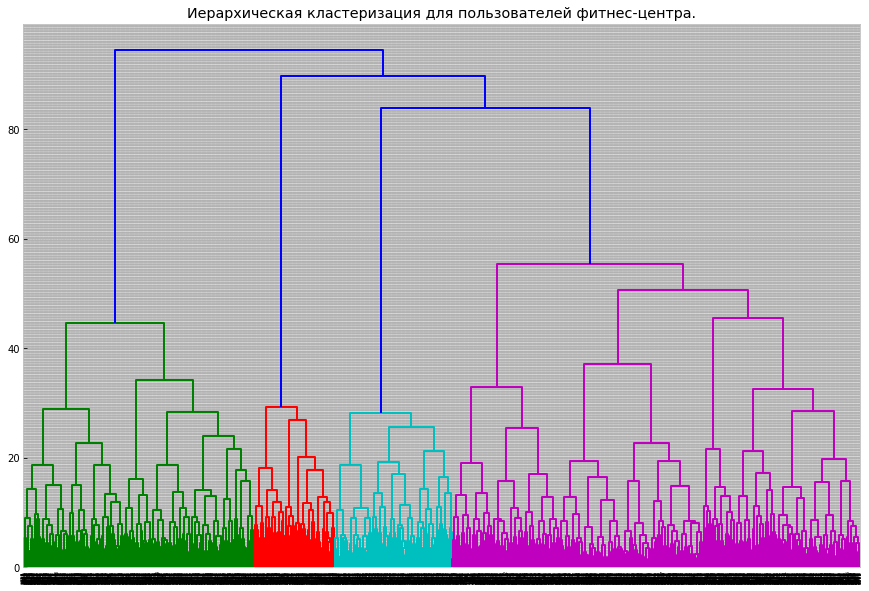

In [42]:
# making dendrogram
linked = linkage(x_st, method = 'ward')
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация для пользователей фитнес-центра.')
plt.show()

        Благодаря построению дендрограммы было установлено, что оптимальное количество групп пользователей услуг фитнес-
    зала - 4. В соответствии с условием задачи, разобьем всю выборку на 5 кластеров и сформируем единую таблицу.

In [28]:
# Setting number of clusters (5)
k_means = KMeans(n_clusters = 5, random_state = 0)
labels = k_means.fit_predict(x_st)

In [29]:
labels_column = pd.Series({'group':labels}) #making Series object for further merging

In [30]:
gym_df['group'] = labels_column['group'].T # adding new column to dataframe

In [31]:
gym_df['group'].value_counts() # examine the values.

3    1158
0    1001
2     898
1     557
4     386
Name: group, dtype: int64

        Кластеризация прошла успешно. Появилось пять классов, столбец с которыми был добавлен к основной базе данных.

[К оглавлению](#home)

#### Анализ кластеров.
<a id="cluster_analysis"></a>

        Итак, выборка былаа разбита на пять групп, отличающихся, по крайней мере, размером. 3-я является наиболее много 
    численной, а вот 4-я - наименее. Проанализируя данные можно будет обнаружить множество дополнительных отличий. 
    Начать стоит с главного: какие из групп состоят из лояльных клиентов, а какие, скорее вссего, разбегутся через месяц? 
    Для решения задачи посчитаем долю оттока в каждой из групп. 

In [32]:
# calculate churn ratio:
for i in [0,1,2,3,4]:
    churn_table = gym_df.loc[gym_df['group'] == i]['churn']
    churn_ratio = len(churn_table.loc[churn_table == 1]) / len(churn_table)
    print('Показатель оттока в группе №',i,'составляет {:.1%}'.format(churn_ratio))

Показатель оттока в группе № 0 составляет 13.3%
Показатель оттока в группе № 1 составляет 40.2%
Показатель оттока в группе № 2 составляет 1.7%
Показатель оттока в группе № 3 составляет 50.6%
Показатель оттока в группе № 4 составляет 26.7%


        Показатели оттока групп сильно отличаются. Группы с наибольшей потерей клиентов - 1 и 3. Рассмотрим средние 
    значения переменных.

In [41]:
# number parameters comparison in both groups
gym_groups_values = gym_df.groupby('group').mean()
gym_groups_values.T

group,0,1,2,3,4
gender,0.498501,0.500898,0.521158,0.512090,0.523316
near_location,0.995005,0.000000,0.995546,1.000000,0.862694
partner,0.889111,0.488330,0.417595,0.196891,0.471503
promo_friends,1.000000,0.077199,0.011136,0.053541,0.305699
phone,1.000000,1.000000,1.000000,1.000000,0.000000
group_visits,0.519481,0.231598,0.546771,0.297064,0.427461
age,29.543457,28.685817,30.805122,27.818653,29.297927
avg_additional_charges_total,152.139417,137.277472,177.103564,124.625600,144.208179
month_to_end_contract,6.265734,2.804309,6.162584,1.898964,4.466321
lifetime,4.210789,2.978456,5.701559,2.058722,3.940415


        Таблицы построены. Глядя на цифры уже можно сделать первичные выводы, однако лучше расписать портрет групп после 
    проведения графического анализа. Так портрет будет наиболее полным.

In [35]:
num_param_2 = ['age',
             'avg_additional_charges_total',
             'month_to_end_contract','lifetime',
             'avg_class_frequency_total']

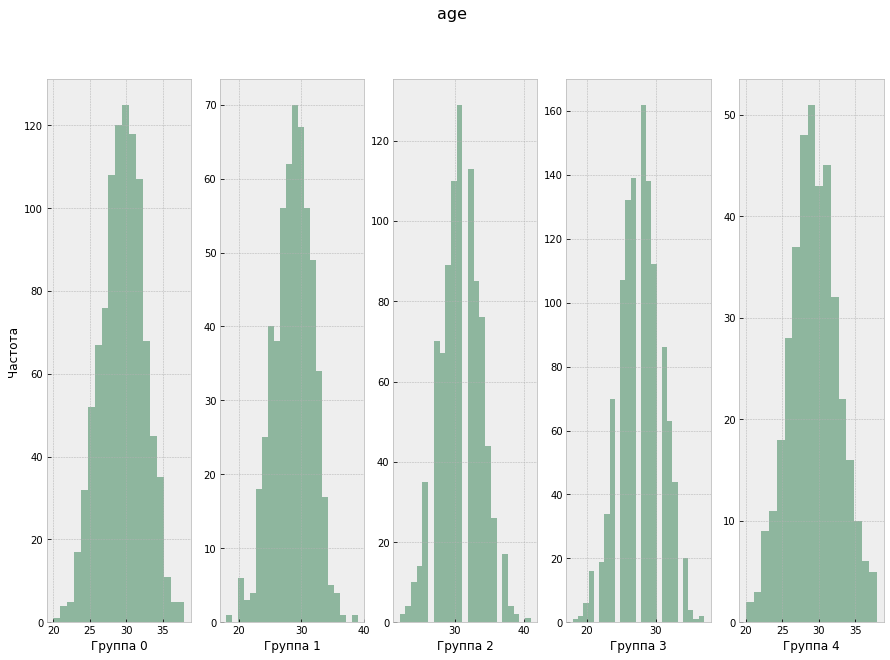

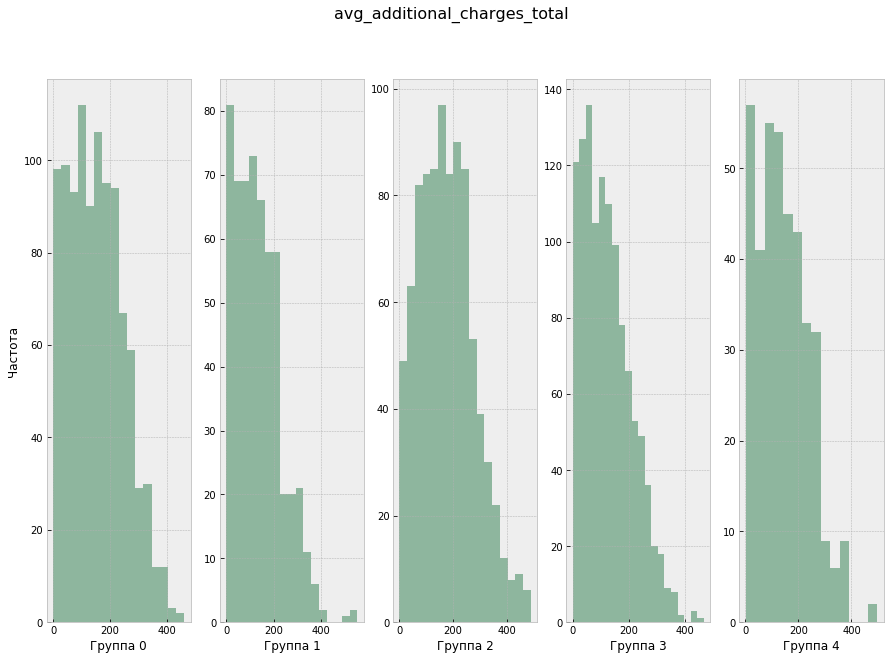

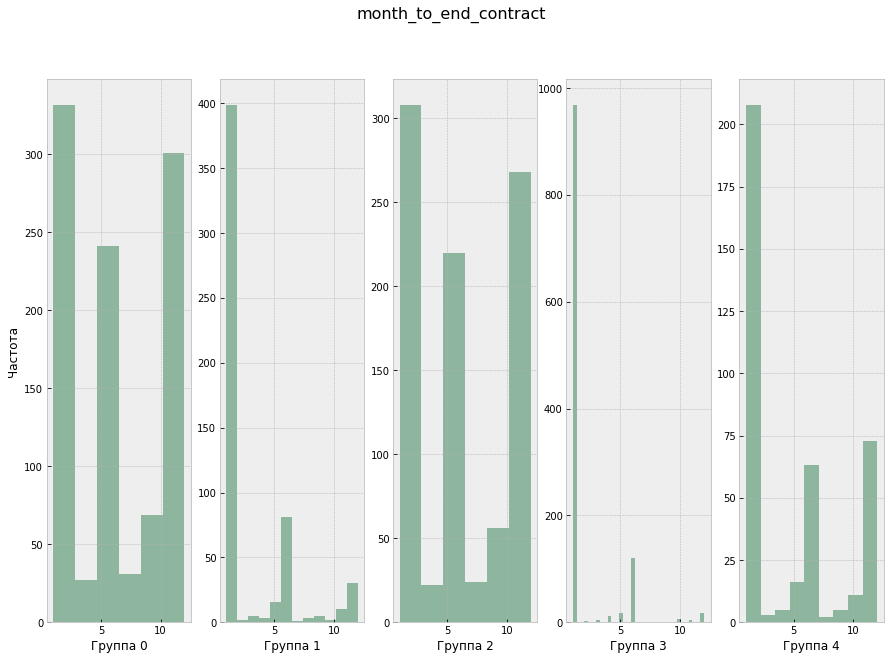

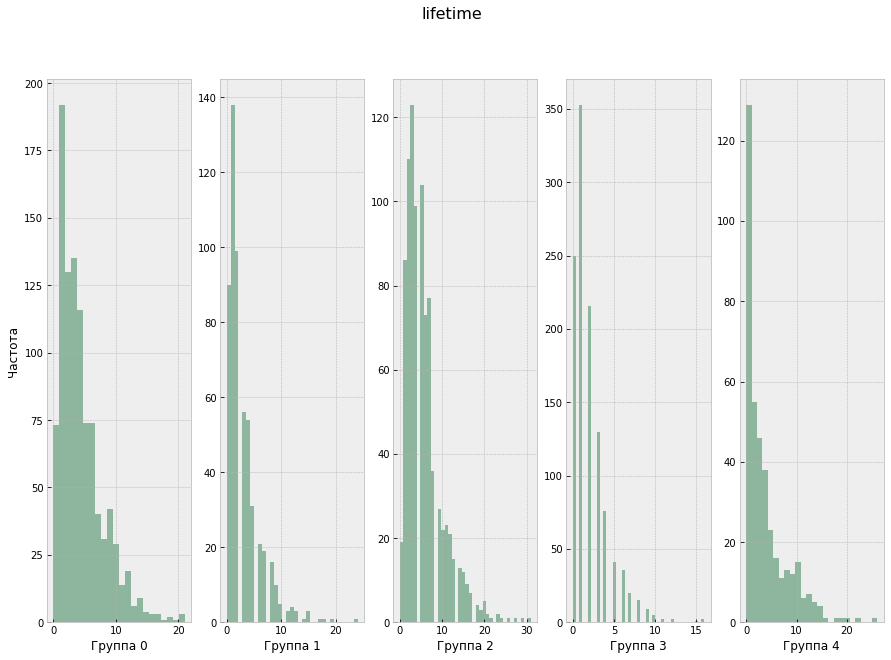

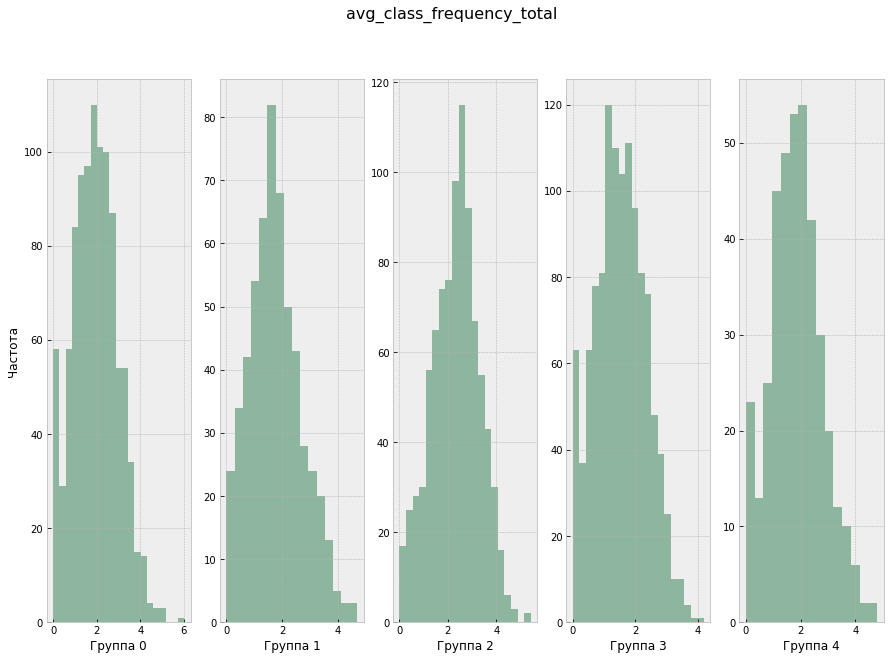

In [36]:
# Set up the matplotlib figure
for column in num_param_2:
    fig, axs = plt.subplots(ncols=5, figsize=(15, 10))
    sb.distplot(gym_df.loc[gym_df['group']== 0][column],kde=False,ax=axs[0],axlabel = 'Группа 0')
    sb.distplot(gym_df.loc[gym_df['group']== 1][column],kde=False,ax=axs[1],axlabel = 'Группа 1')
    sb.distplot(gym_df.loc[gym_df['group']== 2][column],kde=False,ax=axs[2],axlabel = 'Группа 2')
    sb.distplot(gym_df.loc[gym_df['group']== 3][column],kde=False,ax=axs[3],axlabel = 'Группа 3')
    sb.distplot(gym_df.loc[gym_df['group']== 4][column],kde=False,ax=axs[4],axlabel = 'Группа 4')
    fig.suptitle(column, fontsize=16)
    axs[0].set_ylabel("Частота")
    plt.show()

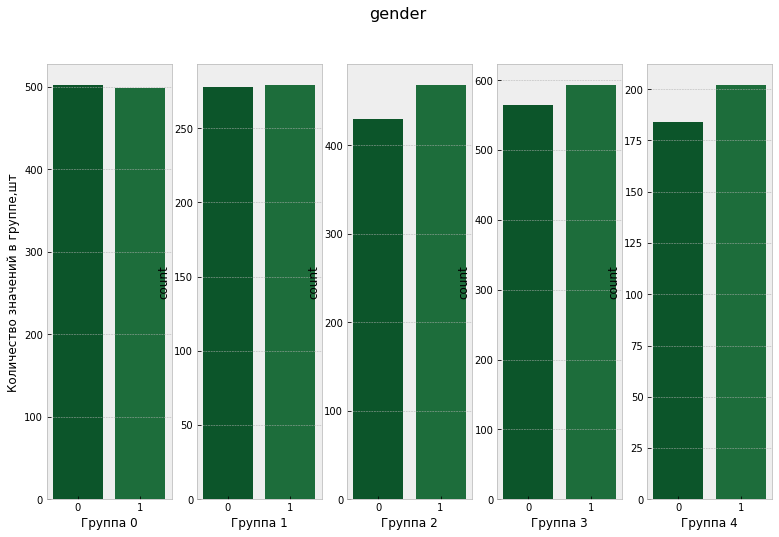

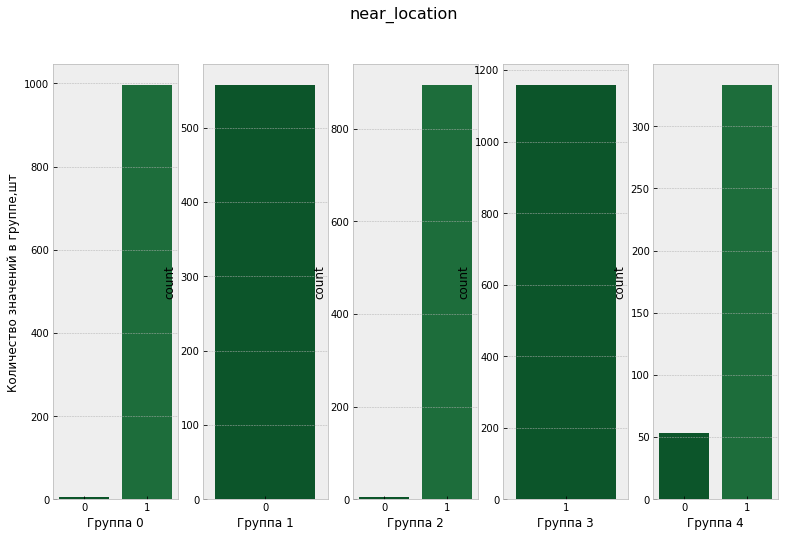

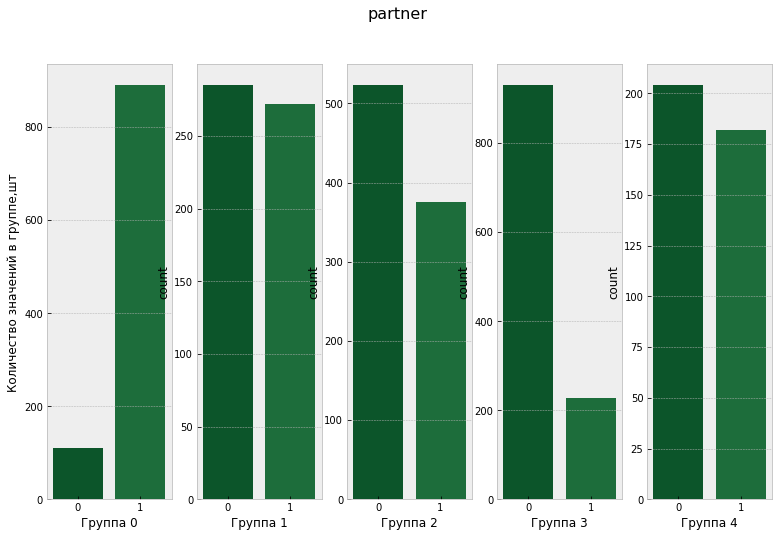

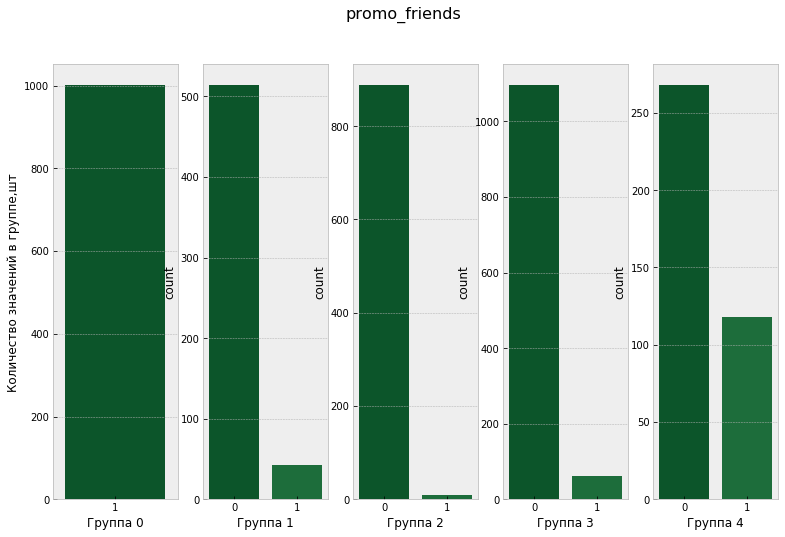

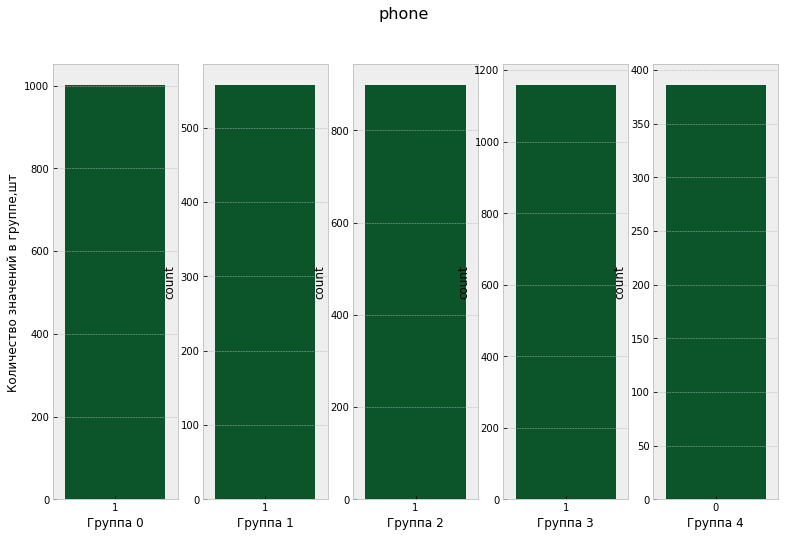

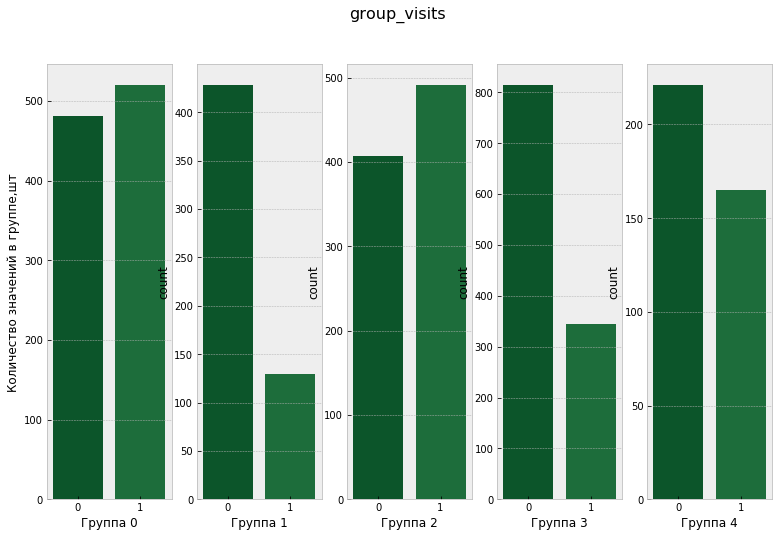

In [37]:
# Set up the matplotlib figure
for column in bin_param:
    fig, axs = plt.subplots(ncols=5,figsize=(13, 8))
    sb.countplot(x=column, data=gym_df.loc[gym_df['group']== 0],ax=axs[0])
    sb.countplot(x=column, data=gym_df.loc[gym_df['group']== 1],ax=axs[1])
    sb.countplot(x=column, data=gym_df.loc[gym_df['group']== 2],ax=axs[2])
    sb.countplot(x=column, data=gym_df.loc[gym_df['group']== 3],ax=axs[3])
    sb.countplot(x=column, data=gym_df.loc[gym_df['group']== 4],ax=axs[4])
    fig.suptitle(column, fontsize=16)
    axs[0].set_ylabel("Количество значений в группе,шт")
    axs[0].set_xlabel('Группа 0')
    axs[1].set_xlabel('Группа 1')
    axs[2].set_xlabel('Группа 2')
    axs[3].set_xlabel('Группа 3')
    axs[4].set_xlabel('Группа 4')
    plt.show()

        Необходимые таблицы и графики построены, можно подвести общие итоги и дать рекомендации.

## Общий вывод и рекомендации.
<a id="summary_stage_5"></a>

        Группа 3 представляет собой людей пола 1, скорее всего новичков: небольшой срок до окончания контракта, низкая 
    посещаемость зала, самое низкое значение lifetime. Представители этой категории не посещают групповых занятисях и не 
    участивуют в программах лояльности. В купе с относительно высоким churn rate именно для этой группы необходимо делать 
    стимулирующие предложения.
        Группа 1 в целом похожа на предыдущую. Ее представители редко ходят в зал и имеют сравнительно низкий lifetime. 
    Показатель partner достаточно высокий, чтобы предположить, что представители группы пользуются привелегиями, которая дает 
    им компания. Эту группу можно считать перспективной, ведь люди редко меняют работу и могут по привычке ходить в клуб, если 
    условия их устраивают. Можно продолжить сегментацию этой группы и предложить новые условия для участников. Для развития 
    социальной составляющей есть смысл проработать специальное расписание групповых занятий.  
        Среди всех групп выделяется группа 2. У нее один из самых низких churn rate и, можно сказать, что ее представители 
    участвуют почти во всех программах лояльности: вовлечены в групповые занятия, работают в компании-партнере, реже приглашали 
    друзей. Можно предположить, что это группа с ощутимой долей людей, которые занимаются рядом с офисом. Для максимизации 
    полезности группы можно также проработать более удобное расписание групповых занятий и стимулировать клиентов приглашать 
    своих коллег на тренировки.
        Группа 0 похожа на 2-ю.Основным отличием является 100%-е участие в акции promo_friends. Чтобы уменьшить отток и 
    увеличить число клиентов можно предложить дополнительные скидки для клиентов этой группы. 
        И, наконец, группа 4.  Это также преимущественно работники партнерских офисов со средними показателями относительно 
    других категорий. Явным отличием является отсутствие контактов ее участников. Общением по 
    почте такую группу будет почти невозможно вернуть, поэтому в первую очередь необходимо получить их контакты. Это можно 
    сделать через специальные таргетированные скидки за верификацию аккаунта (ввода телефона, хотя бы прямо на ресепшене в 
    клубе. Добавить в CRM алерт с инфо об отсутствии номера телефона будет нетрудно).

[К оглавлению](#home)